In [1]:
import torch
import transformers

print("CUDA available:", torch.cuda.is_available())
print("torch version:", torch.__version__)
print("transformers version:", transformers.__version__)


CUDA available: True
torch version: 2.7.1+cu126
transformers version: 4.53.0


# Load Data

In [2]:
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, label_ranking_average_precision_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


labels_df = pd.read_csv("10k_open_source_labels.csv")
with open("10k_open_source_manifests.json", "r") as f:
    manifests = json.load(f)
file_content_map = {entry["file"]: entry["file_content"] for entry in manifests}
labels_df["text"] = labels_df["file"].map(file_content_map)


## Extract and binarize labels

In [3]:
def extract_llm_errors(row):
    all_labels = set(eval(row["kube_linter_new_eids"])
                     + eval(row["terrascan_new_eids"])
                     + eval(row["checkov_new_eids"]))
    return list(label for label in all_labels if label != "no_error")

labels_df["labels"] = labels_df.apply(extract_llm_errors, axis=1)
clean_df = labels_df.dropna(subset=["text"])
clean_df = clean_df[clean_df["labels"].map(len) > 0]

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(clean_df["labels"])
label_names = mlb.classes_

df = pd.DataFrame({
    "text": clean_df["text"].values,
    "labels": list(Y.astype(float))  
})

## Prepare HuggingFace dataset


In [4]:
dataset = Dataset.from_pandas(df)

model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)
    tokens["labels"] = [float(x) for x in example["labels"]]
    return tokens

tokenized = dataset.map(tokenize)
dataset_split = tokenized.train_test_split(test_size=0.1)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
clean_df.head()

,file,kube_linter_eids,kube_linter_new_eids,terrascan_eids,terrascan_new_eids,checkov_eids,checkov_new_eids,text,labels
0,manifest193566.yaml,['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167'],"apiVersion: ""networking.k8s.io/v1""\nkind: ""Ing...",[LLM_error_167]
1,manifest193567.yaml,"['default-service-account', 'dnsconfig-options...","['LLM_error_12', 'LLM_error_145', 'LLM_error_1...","['AC_K8S_0072', 'AC_K8S_0070', 'AC_K8S_0078', ...","['LLM_error_41', 'LLM_error_14', 'LLM_error_43...","['CKV_K8S_20', 'CKV_K8S_11', 'CKV_K8S_30', 'CK...","['LLM_error_8', 'LLM_error_1', 'LLM_error_28',...",apiVersion: apps/v1\nkind: Deployment\nmetadat...,"[LLM_error_28, LLM_error_25, LLM_error_1, LLM_..."
2,manifest193568.yaml,"['default-service-account', 'dnsconfig-options...","['LLM_error_12', 'LLM_error_145', 'LLM_error_1...","['AC_K8S_0086', 'AC_K8S_0085', 'AC_K8S_0064', ...","['LLM_error_9', 'LLM_error_52', 'LLM_error_28'...","['CKV_K8S_20', 'CKV_K8S_30', 'CKV_K8S_21', 'CK...","['LLM_error_8', 'LLM_error_28', 'LLM_error_9',...",apiVersion: apps/v1\nkind: Deployment\nmetadat...,"[LLM_error_28, LLM_error_25, LLM_error_104, LL..."
3,manifest193569.yaml,['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167'],apiVersion: v1\nkind: PersistentVolumeClaim\nm...,[LLM_error_167]
4,manifest19356.yaml,"['default-service-account', 'dnsconfig-options...","['LLM_error_12', 'LLM_error_145', 'LLM_error_1...","['AC_K8S_0085', 'AC_K8S_0098', 'AC_K8S_0097', ...","['LLM_error_52', 'LLM_error_1', 'LLM_error_169...","['CKV_K8S_20', 'CKV_K8S_11', 'CKV_K8S_10', 'CK...","['LLM_error_8', 'LLM_error_1', 'LLM_error_22',...",# Copyright 2016 The Kubernetes Authors All ri...,"[LLM_error_28, LLM_error_25, LLM_error_1, LLM_..."


In [9]:
df.to_csv('dataset_processed.csv', index=False) 

# Train model

## Set Metrics

In [7]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    label_ranking_average_precision_score,
    coverage_error
)

def precision_recall_at_k(probs, labels, k=5):
    batch_size, num_labels = probs.shape
    precision_list = []
    recall_list = []

    for i in range(batch_size):
        true = set(np.where(labels[i] == 1)[0])
        if len(true) == 0:
            continue  # skip if no ground truth

        topk = set(np.argsort(probs[i])[::-1][:k])
        n_correct = len(true & topk)

        precision_list.append(n_correct / k)
        recall_list.append(n_correct / len(true))

    return np.mean(precision_list), np.mean(recall_list)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Standard strict metrics
    strict_precision = precision_score(labels, preds, average="micro", zero_division=0)
    strict_recall = recall_score(labels, preds, average="micro", zero_division=0)
    strict_f1 = f1_score(labels, preds, average="micro", zero_division=0)

    # Lenient (noisy label-aware) metrics
    true_positives = np.sum((labels == 1) & (preds == 1))
    predicted_positives = np.sum(preds == 1)
    possible_positives = np.sum(labels == 1)

    lenient_precision = true_positives / predicted_positives if predicted_positives > 0 else 0.0
    lenient_recall = true_positives / possible_positives if possible_positives > 0 else 0.0
    lenient_f1 = (2 * lenient_precision * lenient_recall) / (lenient_precision + lenient_recall + 1e-8)

    # Ranking-based metrics
    lrap = label_ranking_average_precision_score(labels, probs)
    cov_err = coverage_error(labels, probs)  

    # Precision@K and Recall@K
    p_at_3, r_at_3 = precision_recall_at_k(probs, labels, k=3)
    p_at_5, r_at_5 = precision_recall_at_k(probs, labels, k=5)

    return {
        "strict_precision": strict_precision,
        "strict_recall": strict_recall,
        "strict_f1": strict_f1,
        "lenient_precision": lenient_precision,
        "lenient_recall": lenient_recall,
        "lenient_f1": lenient_f1,
        "lrap": lrap,
        "coverage_error": cov_err,
        "precision@3": p_at_3,
        "recall@3": r_at_3,
        "precision@5": p_at_5,
        "recall@5": r_at_5
    }


## Load model

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_names),
    problem_type="multi_label_classification"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train model

In [ ]:
args = TrainingArguments(
    output_dir="./codebert-k8-finetuned",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    eval_steps=100,
    logging_steps=100,
    save_steps=100,
    num_train_epochs=100,
    learning_rate=2e-5,
    fp16=True,
    logging_dir="./logs",
    load_best_model_at_end=True,
    gradient_accumulation_steps = 1,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# === Train ===
trainer.train()

# === Evaluate after training ===
metrics = trainer.evaluate()
print("📊 Final Evaluation Metrics:", metrics)

# === Save model and label mapping ===
model.save_pretrained("./codebert-k8-finetuned")
tokenizer.save_pretrained("./codebert-k8-finetuned")
pd.Series(label_names).to_csv("label_names.csv", index=False)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_391297/838241924.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Strict Precision,Strict Recall,Strict F1,Lenient Precision,Lenient Recall,Lenient F1,Lrap,Coverage Error,Precision@3,Recall@3,Precision@5,Recall@5
1,0.436300,0.200481,0.917584,0.867074,0.891614,0.917584,0.867074,0.891614,0.890264,33.643000,0.704333,0.547783,0.584600,0.572590
2,0.203200,0.115264,0.915100,0.883384,0.898963,0.915100,0.883384,0.898963,0.901701,24.488000,0.705333,0.550316,0.588000,0.575694
3,0.103300,0.091059,0.913230,0.880462,0.896547,0.913230,0.880462,0.896547,0.920547,21.580000,0.708333,0.550666,0.603400,0.600447
4,0.089900,0.080186,0.901069,0.910499,0.905760,0.901069,0.910499,0.905760,0.924059,20.407000,0.708333,0.550660,0.610000,0.616033
5,0.075600,0.072654,0.917368,0.903840,0.910554,0.917368,0.903840,0.910554,0.929716,19.735000,0.709333,0.550776,0.611200,0.616260
6,0.070600,0.066864,0.914313,0.917295,0.915802,0.914313,0.917295,0.915802,0.935309,19.278000,0.709667,0.550813,0.611600,0.616338
7,0.066500,0.062476,0.917765,0.927557,0.922635,0.917765,0.927557,0.922635,0.936430,18.908000,0.709667,0.550813,0.612000,0.616434
8,0.060900,0.059205,0.923691,0.927897,0.925789,0.923691,0.927897,0.925789,0.939416,18.610000,0.709667,0.550813,0.612400,0.616510
9,0.057500,0.056420,0.925259,0.928780,0.927016,0.925259,0.928780,0.927016,0.947381,18.393000,0.721667,0.568813,0.612400,0.616514
10,0.052900,0.052230,0.930924,0.927761,0.929340,0.930924,0.927761,0.929340,0.958010,18.192000,0.726000,0.573979,0.619000,0.627514


📊 Final Evaluation Metrics: {'eval_loss': 0.01920604705810547, 'eval_strict_precision': 0.9797219396405561, 'eval_strict_recall': 0.981719334012912, 'eval_strict_f1': 0.9807196198234894, 'eval_lenient_precision': 0.9797219396405561, 'eval_lenient_recall': 0.981719334012912, 'eval_lenient_f1': 0.9807196148234947, 'eval_lrap': 0.9934487666423273, 'eval_coverage_error': 15.799, 'eval_precision@3': 0.7636666666666667, 'eval_recall@3': 0.6144072046946012, 'eval_precision@5': 0.6294, 'eval_recall@5': 0.6469627832663403, 'eval_runtime': 1.8782, 'eval_samples_per_second': 532.415, 'eval_steps_per_second': 8.519, 'epoch': 60.0}


# Evaluate model

## Examples

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd

# === Load model and tokenizer ===
model_path = "./codebert-k8-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Load label names ===
label_names = pd.read_csv("label_names.csv").values.flatten().tolist()

# === Inference function ===
def predict_labels(text, threshold=0.5):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        preds = (probs >= threshold).astype(int)
        predicted_labels = [label for p, label in zip(preds, label_names) if p == 1]
    return predicted_labels, probs

# === Example: Load from test set ===
df = pd.read_csv("10k_open_source_labels.csv")
with open("10k_open_source_manifests.json") as f:
    file_content_map = {entry["file"]: entry["file_content"] for entry in json.load(f)}

# Pick a test sample (e.g., index 0)
idx = 13
text = file_content_map[df.loc[idx, "file"]]
true_labels = set(eval(df.loc[idx, "kube_linter_new_eids"]) + 
                  eval(df.loc[idx, "terrascan_new_eids"]) +
                  eval(df.loc[idx, "checkov_new_eids"]))

true_labels = [l for l in true_labels if l != "no_error"]

# === Predict ===
predicted_labels, probs = predict_labels(text)

# === Output ===
print("✅ Ground Truth Labels:", sorted(true_labels))
print("🧠 Predicted Labels:", sorted(predicted_labels))


✅ Ground Truth Labels: ['LLM_error_1', 'LLM_error_102', 'LLM_error_104', 'LLM_error_11', 'LLM_error_12', 'LLM_error_14', 'LLM_error_145', 'LLM_error_150', 'LLM_error_160', 'LLM_error_161', 'LLM_error_162', 'LLM_error_163', 'LLM_error_169', 'LLM_error_170', 'LLM_error_2', 'LLM_error_22', 'LLM_error_25', 'LLM_error_28', 'LLM_error_3', 'LLM_error_31', 'LLM_error_32', 'LLM_error_34', 'LLM_error_41', 'LLM_error_42', 'LLM_error_43', 'LLM_error_47', 'LLM_error_49', 'LLM_error_50', 'LLM_error_52', 'LLM_error_53', 'LLM_error_8', 'LLM_error_99']
🧠 Predicted Labels: ['LLM_error_1', 'LLM_error_102', 'LLM_error_104', 'LLM_error_11', 'LLM_error_12', 'LLM_error_14', 'LLM_error_145', 'LLM_error_150', 'LLM_error_154', 'LLM_error_160', 'LLM_error_161', 'LLM_error_162', 'LLM_error_163', 'LLM_error_169', 'LLM_error_170', 'LLM_error_2', 'LLM_error_22', 'LLM_error_23', 'LLM_error_25', 'LLM_error_28', 'LLM_error_3', 'LLM_error_31', 'LLM_error_32', 'LLM_error_34', 'LLM_error_41', 'LLM_error_42', 'LLM_error_43

## Plots

100%|██████████| 10000/10000 [00:55<00:00, 179.26it/s]


✅ Saved model-only error list to model_only_errors.csv


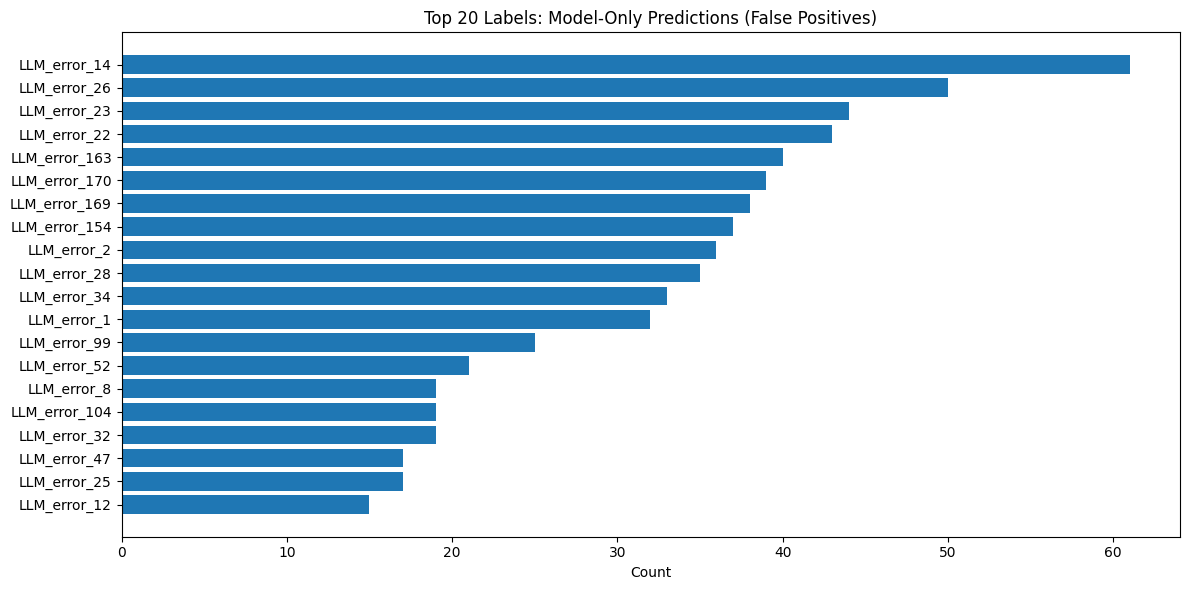

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
%matplotlib inline

# === Load model and tokenizer ===
model_path = "./codebert-k8-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Move model to GPU if available ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Load label names ===
label_names = pd.read_csv("label_names.csv").values.flatten().tolist()

# === Load dataset ===
df = pd.read_csv("10k_open_source_labels.csv")
with open("10k_open_source_manifests.json") as f:
    file_content_map = {entry["file"]: entry["file_content"] for entry in json.load(f)}

# === Pre-extract true labels for faster access ===
def extract_true_labels(row):
    labels = set(eval(row["kube_linter_new_eids"]) + 
                 eval(row["terrascan_new_eids"]) + 
                 eval(row["checkov_new_eids"]))
    return set(label for label in labels if label != "no_error")

df["true_labels"] = df.apply(extract_true_labels, axis=1)

# === Batch inference ===
BATCH_SIZE = 256
model_only_counter = Counter()
scanner_only_counter = Counter()
model_fp_records = []

texts = []
true_label_batch = []
file_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    content = file_content_map.get(row["file"])
    if not content:
        continue
    texts.append(content)
    true_label_batch.append(row["true_labels"])
    file_indices.append(idx)

    if len(texts) == BATCH_SIZE or idx == df.index[-1]:
        inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()

        preds_batch = (probs >= 0.5).astype(int)

        for i in range(len(texts)):
            pred_labels = set([label for p, label in zip(preds_batch[i], label_names) if p == 1])
            true_labels = true_label_batch[i]
            row_idx = file_indices[i]
            row_file = df.loc[row_idx, "file"]

            false_positives = pred_labels - true_labels
            false_negatives = true_labels - pred_labels

            model_only_counter.update(false_positives)
            scanner_only_counter.update(false_negatives)

            for err in false_positives:
                model_fp_records.append({
                    "error_id": err,
                    "file_index": row_idx,
                    "file": row_file
                })

        # Reset batch
        texts = []
        true_label_batch = []
        file_indices = []

# === Save CSV with model-only errors ===
fp_df = pd.DataFrame(model_fp_records)
fp_df.to_csv("model_only_errors.csv", index=False)
print("✅ Saved model-only error list to model_only_errors.csv")

# === Plot top model-only mistakes ===
most_common_fp = model_only_counter.most_common(20)
if most_common_fp:
    labels_fp, counts_fp = zip(*most_common_fp)
    plt.figure(figsize=(12, 6))
    plt.barh(labels_fp, counts_fp)
    plt.xlabel("Count")
    plt.title("Top 20 Labels: Model-Only Predictions (False Positives)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No model-only false positives found.")


In [10]:
import yaml

# Filter to just LLM_error_26
fp_26 = fp_df[fp_df["error_id"] == "LLM_error_26"]

# Go through each matching file
for _, row in fp_26.iterrows():
    file = row["file"]
    content = file_content_map.get(file)

    print(f"\n📄 File: {file} (index {row['file_index']})")

    if not content:
        print("⚠️ File content not found.")
        continue

    try:
        manifest = yaml.safe_load(content)
    except Exception as e:
        print(f"⚠️ Failed to parse YAML: {e}")
        continue

    # Recursive search for all securityContext blocks
    def find_security_contexts(obj):
        found = []
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == "securityContext":
                    found.append(v)
                else:
                    found.extend(find_security_contexts(v))
        elif isinstance(obj, list):
            for item in obj:
                found.extend(find_security_contexts(item))
        return found

    contexts = find_security_contexts(manifest)

    if not contexts:
        print("❌ No securityContext found.")
    else:
        for i, ctx in enumerate(contexts):
            print(f"🔐 securityContext [{i+1}]: {ctx}")



📄 File: manifest193670.yaml (index 213)
🔐 securityContext [1]: {}

📄 File: manifest193699.yaml (index 244)
🔐 securityContext [1]: {'sysctls': [{'name': 'net.ipv4.tcp_keepalive_time', 'value': '60'}, {'name': 'net.ipv4.tcp_keepalive_intvl', 'value': '30'}]}

📄 File: manifest193787.yaml (index 337)
🔐 securityContext [1]: {'runAsGroup': 65532, 'runAsNonRoot': True, 'runAsUser': 65532}
🔐 securityContext [2]: {'runAsNonRoot': True, 'runAsUser': 65534}

📄 File: manifest194612.yaml (index 1226)
🔐 securityContext [1]: {}

📄 File: manifest194964.yaml (index 1702)
🔐 securityContext [1]: {}

📄 File: manifest19518.yaml (index 1943)
🔐 securityContext [1]: {'fsGroup': 0}
🔐 securityContext [2]: {'privileged': True, 'runAsUser': 0}

📄 File: manifest195839.yaml (index 2740)
🔐 securityContext [1]: {'fsGroup': 1000}
🔐 securityContext [2]: {'privileged': True, 'runAsUser': 0}

📄 File: manifest196103.yaml (index 3030)
🔐 securityContext [1]: {'fsGroup': 1000}
🔐 securityContext [2]: {'privileged': True}

📄 

In [21]:
import yaml

# === Helpers ===

def find_security_contexts(obj):
    found = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if k == "securityContext":
                found.append(v)
            else:
                found.extend(find_security_contexts(v))
    elif isinstance(obj, list):
        for item in obj:
            found.extend(find_security_contexts(item))
    return found


def find_resource_issues(manifest):
    cpu_issues = False
    mem_issues = False

    def recurse(obj):
        nonlocal cpu_issues, mem_issues
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == "containers" and isinstance(v, list):
                    for container in v:
                        requests = container.get("resources", {}).get("requests", {})
                        cpu = requests.get("cpu")
                        memory = requests.get("memory")

                        # CPU: missing or zero
                        if cpu is None or str(cpu).strip() in ("0", "0m", ""):
                            cpu_issues = True
                        # Memory: missing or zero
                        if memory is None or str(memory).strip() in ("0", "0Mi", "0M", "0Gi", ""):
                            mem_issues = True
                else:
                    recurse(v)
        elif isinstance(obj, list):
            for item in obj:
                recurse(item)

    recurse(manifest)
    return cpu_issues, mem_issues


# === File filtering ===

# Filter relevant errors
fp_22 = fp_df[fp_df["error_id"] == "LLM_error_22"]
fp_23 = fp_df[fp_df["error_id"] == "LLM_error_23"]
fp_26 = fp_df[fp_df["error_id"] == "LLM_error_26"]

# Unique file list
# Only consider false positives (LLM predicted, traditional tools didn't) that are actually buggy
verified_fp_22 = fp_22[fp_22["file"].isin(files_bad_cpu)]
verified_fp_23 = fp_23[fp_23["file"].isin(files_bad_mem)]
verified_fp_26 = fp_26[fp_26["file"].isin(files_empty_sc)]

# Combine only verified false positives
unique_files = pd.concat([verified_fp_22, verified_fp_23, verified_fp_26]).drop_duplicates(subset="file")

# === Tracking results ===
files_empty_sc = set()
files_bad_cpu = set()
files_bad_mem = set()

# === Process each file ===
for _, row in unique_files.iterrows():
    file = row["file"]
    content = file_content_map.get(file)
    if not content:
        continue

    try:
        manifest = yaml.safe_load(content)
    except Exception:
        continue

    # Check securityContext
    contexts = find_security_contexts(manifest)
    if any(isinstance(ctx, dict) and not ctx for ctx in contexts):
        files_empty_sc.add(file)

    # Check CPU/memory issues
    has_bad_cpu, has_bad_mem = find_resource_issues(manifest)
    if has_bad_cpu:
        files_bad_cpu.add(file)
    if has_bad_mem:
        files_bad_mem.add(file)

# === Results ===

print(f"🔐 Files with empty securityContext (LLM_error_26): {len(files_empty_sc)}")
print(f"🧠 Files with bad memory requests (LLM_error_23): {len(files_bad_mem)}")
print(f"🧮 Files with bad CPU requests (LLM_error_22): {len(files_bad_cpu)}")



🔐 Files with empty securityContext (LLM_error_26): 23
🧠 Files with bad memory requests (LLM_error_23): 41
🧮 Files with bad CPU requests (LLM_error_22): 42


In [22]:
def patch_labels(row):
    new_labels = set(row["labels"])  # Existing labels (assumed to be a list)
    if row["file"] in files_empty_sc:
        new_labels.add("LLM_error_26")
    if row["file"] in files_bad_cpu:
        new_labels.add("LLM_error_22")
    if row["file"] in files_bad_mem:
        new_labels.add("LLM_error_23")
    return list(new_labels)

labels_df["labels"] = labels_df.apply(patch_labels, axis=1)

print("✅ Updated `labels_df` with new LLM_error_22/23/26 based on YAML structure.")

✅ Updated `labels_df` with new LLM_error_22/23/26 based on YAML structure.


In [23]:
labels_df[labels_df["file"].isin(list(files_empty_sc)[:1])]


,file,kube_linter_eids,kube_linter_new_eids,terrascan_eids,terrascan_new_eids,checkov_eids,checkov_new_eids,text,labels
3334,manifest109624.yaml,"['dnsconfig-options', 'minimum-three-replicas'...","['LLM_error_145', 'LLM_error_150', 'LLM_error_...","['AC_K8S_0087', 'AC_K8S_0085', 'AC_K8S_0078', ...","['LLM_error_25', 'LLM_error_52', 'LLM_error_43...","['CKV_K8S_20', 'CKV_K8S_21', 'CKV_K8S_28', 'CK...","['LLM_error_8', 'LLM_error_9', 'LLM_error_11',...",---\n# Source: opentelemetry-collector/templat...,"[LLM_error_8, LLM_error_102, LLM_error_104, LL..."


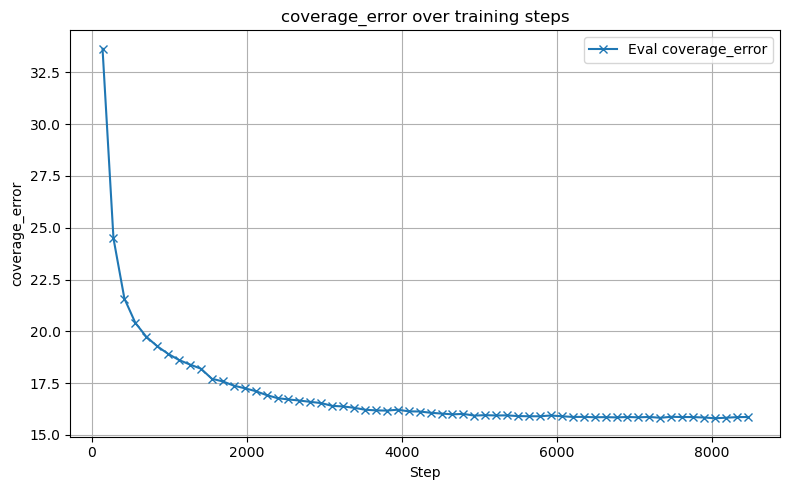

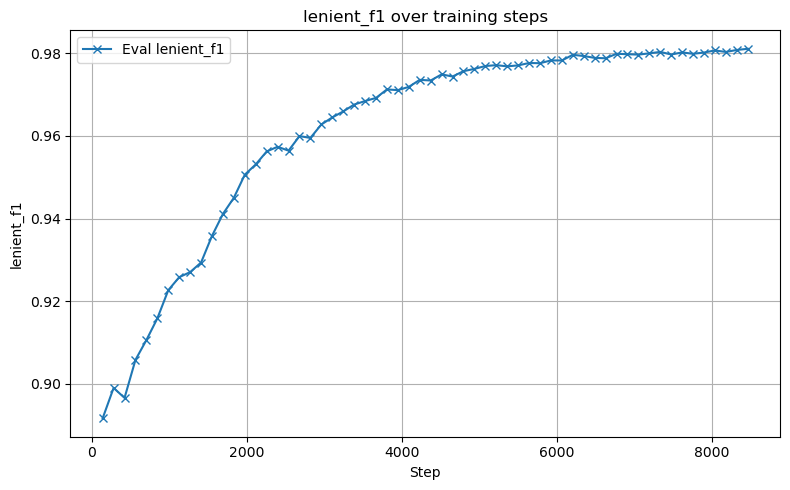

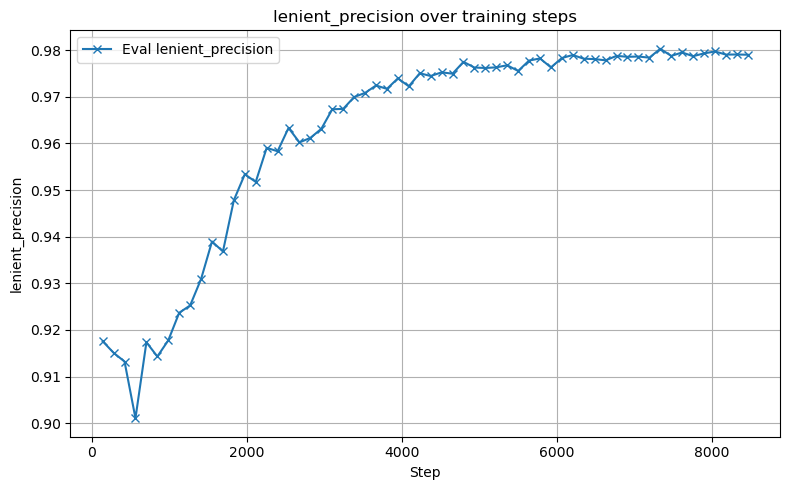

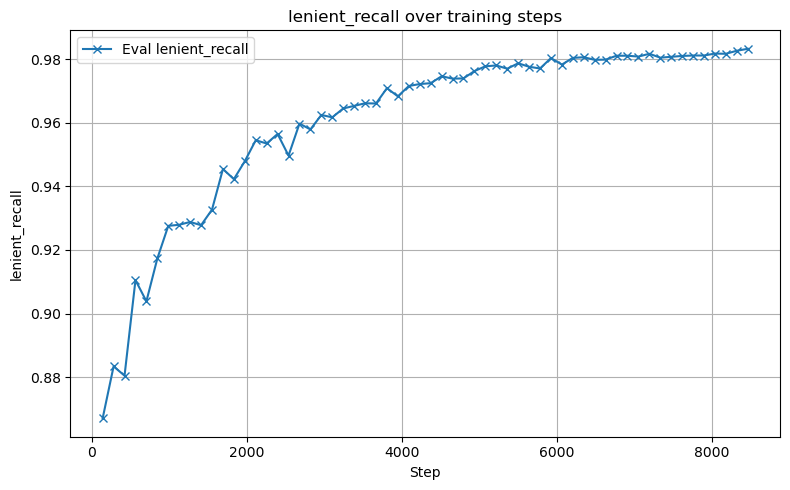

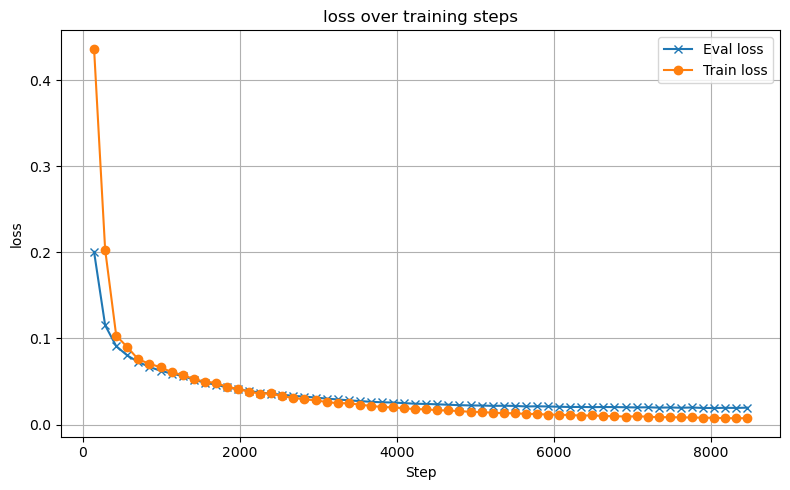

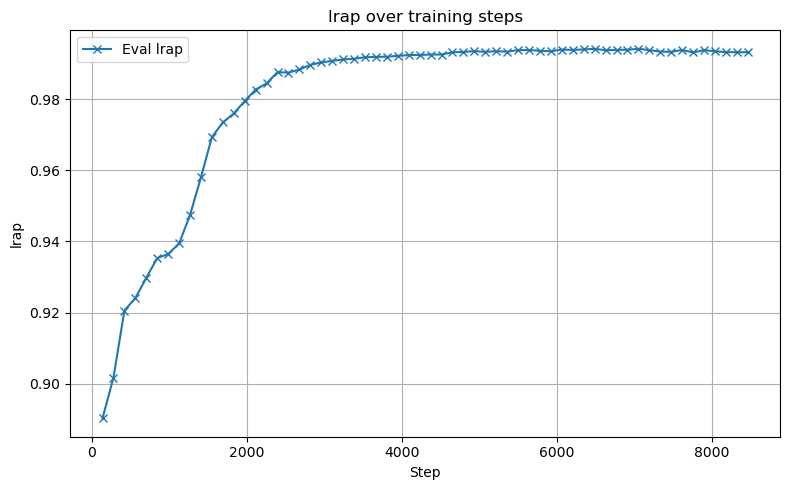

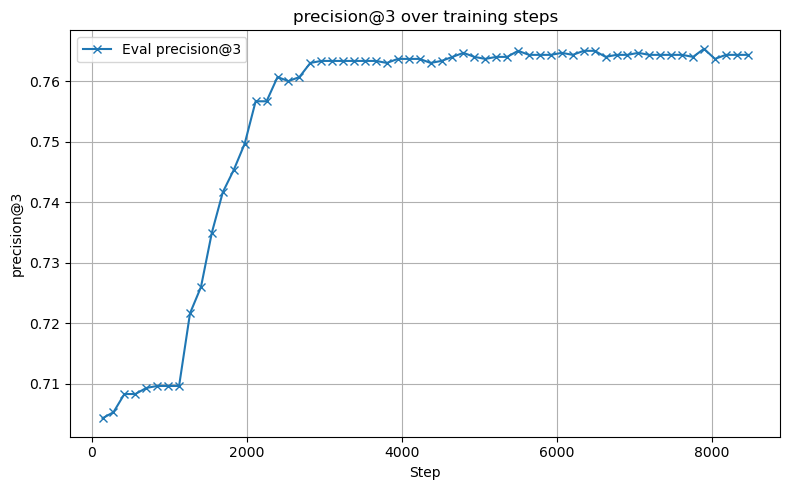

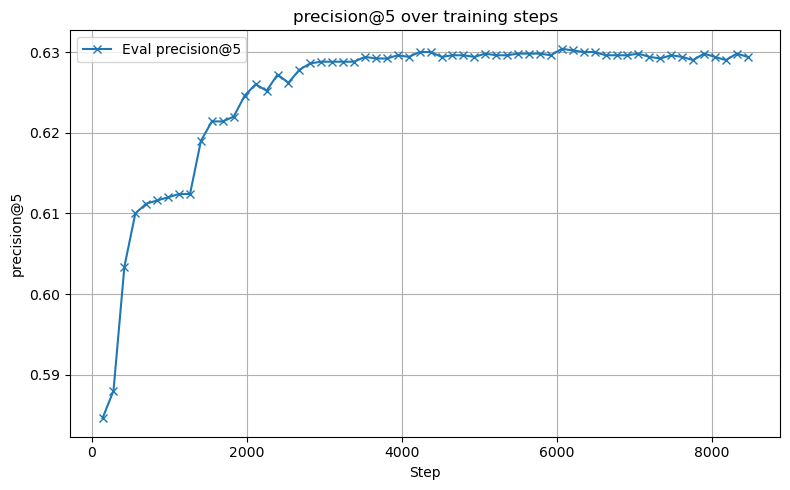

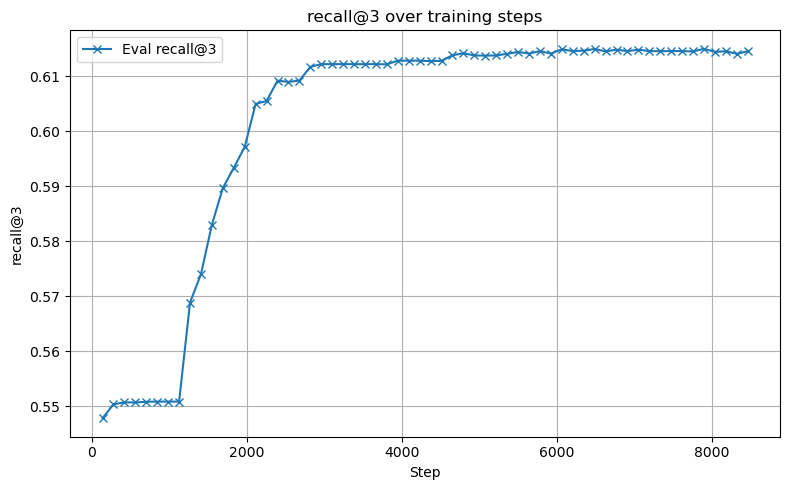

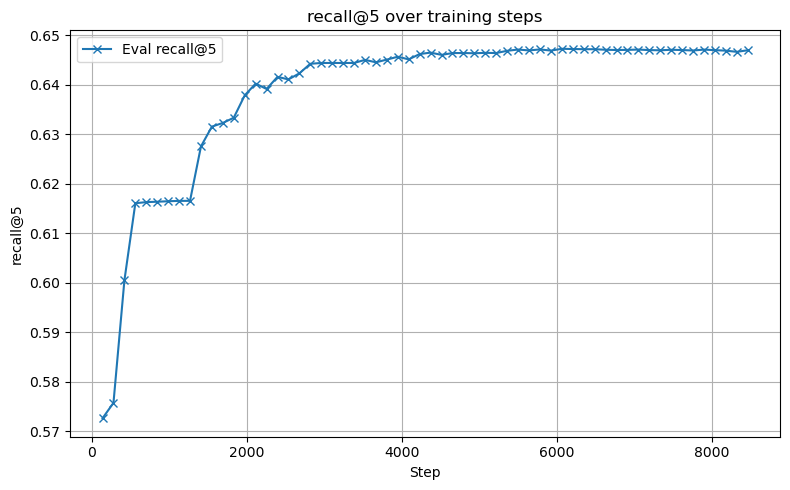

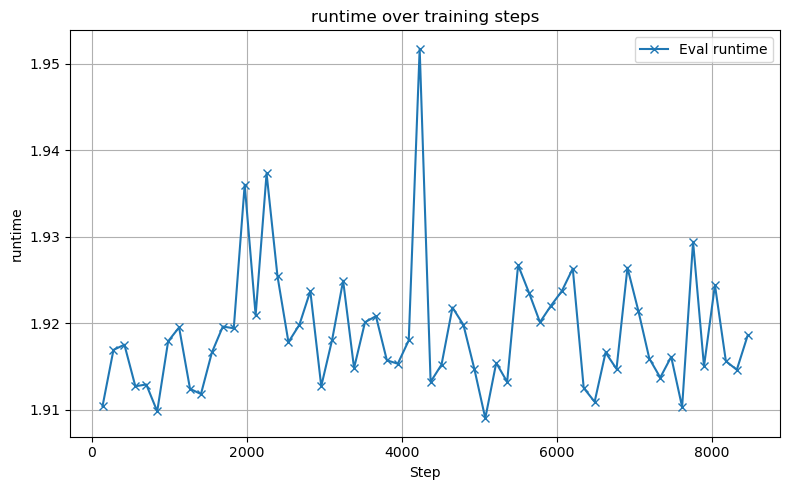

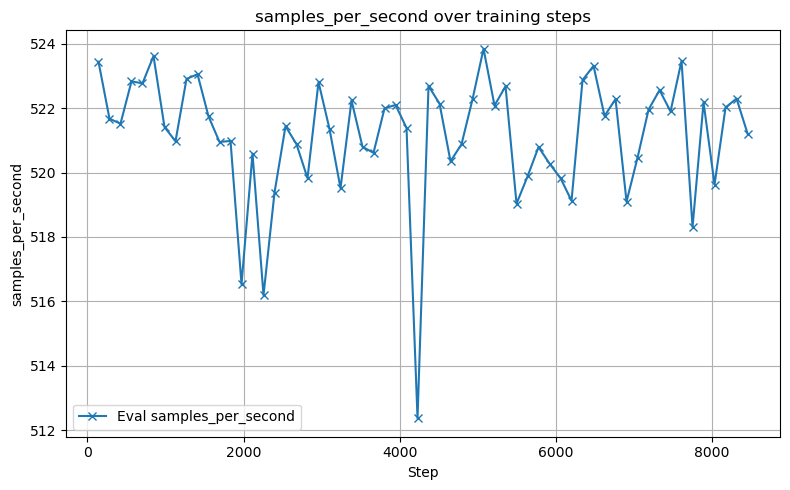

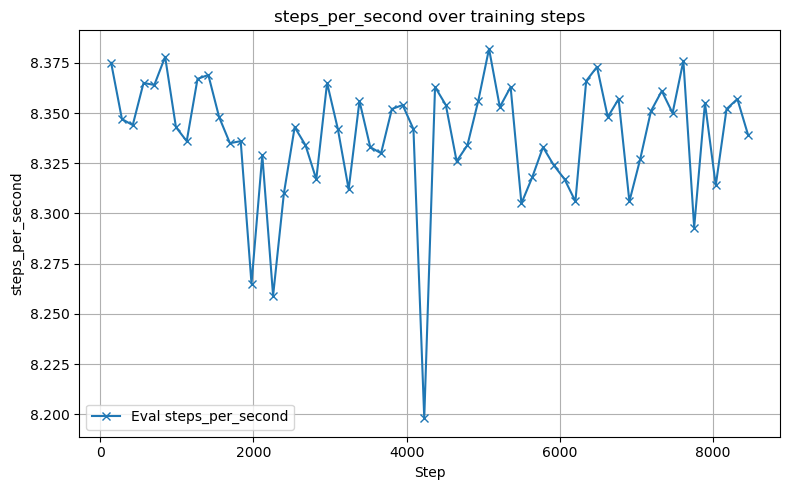

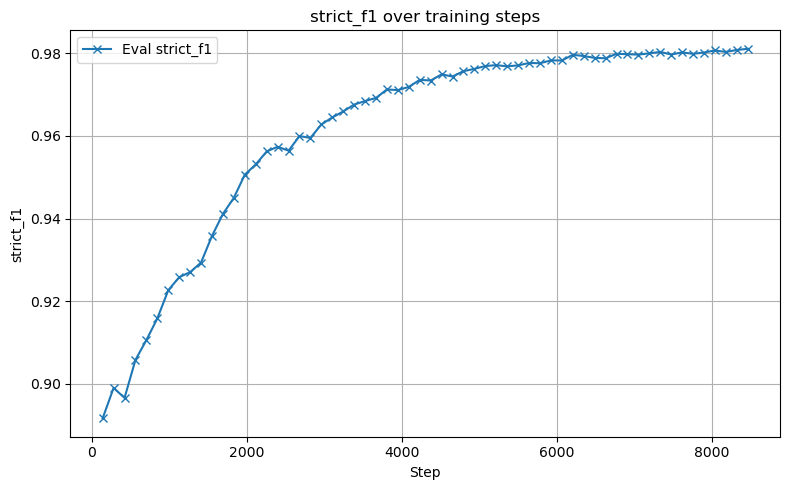

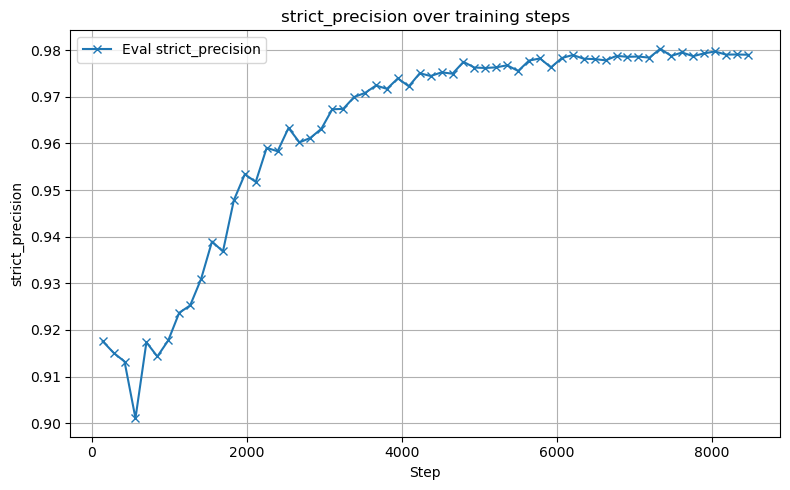

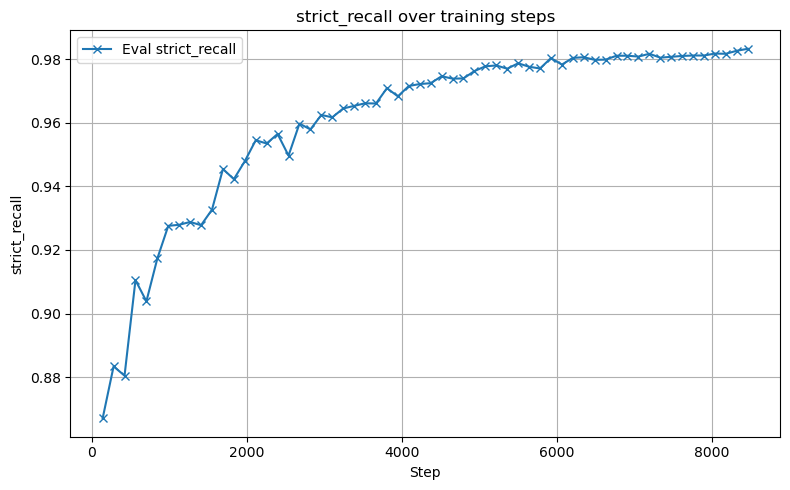

In [11]:
import json
import glob
import matplotlib.pyplot as plt
import collections

# Get sorted trainer_state.json files
files = sorted(
    glob.glob("codebert-k8-finetuned/checkpoint-*/trainer_state.json"),
    key=lambda x: int(x.split("checkpoint-")[1].split("/")[0])
)

steps = []
train_metrics = collections.defaultdict(list)
eval_metrics = collections.defaultdict(list)

for file in files:
    with open(file) as f:
        data = json.load(f)
        logs = data.get("log_history", [])

        # Get last eval log (we require it to proceed)
        eval_log = next((log for log in reversed(logs) if "eval_loss" in log), None)
        if not eval_log:
            continue

        step = eval_log["step"]
        steps.append(step)

        # Store eval metrics
        for k, v in eval_log.items():
            if k.startswith("eval_") and k != "step":
                metric_name = k.replace("eval_", "")
                eval_metrics[metric_name].append(v)

        # Get corresponding train log (same step or closest before)
        train_log = next((log for log in reversed(logs) if "loss" in log and "eval_loss" not in log), None)
        for metric in eval_metrics:
            if train_log and metric in train_log:
                train_metrics[metric].append(train_log[metric])
            else:
                train_metrics[metric].append(None)  # pad missing with None

# Plot aligned metrics
for metric in sorted(eval_metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(steps, eval_metrics[metric], label=f"Eval {metric}", marker='x')
    if all(train_metrics[metric]):
        plt.plot(steps, train_metrics[metric], label=f"Train {metric}", marker='o')
    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.title(f"{metric} over training steps")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [24]:
# === Filter valid examples ===
clean_df = labels_df.dropna(subset=["text"])
clean_df = clean_df[clean_df["labels"].map(len) > 0]

# === Binarize labels ===
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(clean_df["labels"])
label_names = mlb.classes_  # Save this to use in prediction later if needed

# === Prepare Dataset ===
df = pd.DataFrame({
    "text": clean_df["text"].values,
    "labels": list(Y.astype(float))
})
dataset = Dataset.from_pandas(df)

In [25]:
tokenized_dataset = dataset.map(tokenize)
dataset_split = tokenized_dataset.train_test_split(test_size=0.1)

# === Model ===
model = AutoModelForSequenceClassification.from_pretrained(
    "./codebert-k8-finetuned",
    num_labels=len(label_names),
    problem_type="multi_label_classification"
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [26]:
args = TrainingArguments(
    output_dir="./codebert-k8-finetuned",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",           
    save_strategy="epoch",
    eval_steps=30,
    logging_steps=30,
    save_steps=30,
    num_train_epochs=30,
    learning_rate=1e-5,
    fp16=True,
    logging_dir="./logs",
    load_best_model_at_end=True,
    gradient_accumulation_steps = 1,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  
)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# === Train ===
trainer.train()

# === Evaluate after training ===
metrics = trainer.evaluate()
print("📊 Final Evaluation Metrics:", metrics)

# === Save model and label mapping ===
trainer.save_model("./codebert-k8-refinetuned")
tokenizer.save_pretrained("./codebert-k8-refinetuned")
pd.Series(label_names).to_csv("llm_label_names_refined.csv", index=False)

/tmp/ipykernel_4186427/4282094530.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Strict Precision,Strict Recall,Strict F1,Lenient Precision,Lenient Recall,Lenient F1,Lrap,Coverage Error,Precision@3,Recall@3,Precision@5,Recall@5
1,0.009200,0.007692,0.995217,0.992776,0.993995,0.995217,0.992776,0.993995,0.998811,15.422000,0.762333,0.602869,0.635000,0.636332
2,0.008800,0.007593,0.994689,0.993041,0.993865,0.994689,0.993041,0.993865,0.998669,15.428000,0.762333,0.602869,0.635000,0.636332
3,0.007800,0.007563,0.993902,0.993837,0.993870,0.993902,0.993837,0.993869,0.998784,15.427000,0.762333,0.602869,0.635000,0.636332
4,0.007300,0.007419,0.994429,0.993770,0.994100,0.994429,0.993770,0.994100,0.998595,15.429000,0.762333,0.602869,0.635000,0.636332
5,0.008000,0.007342,0.994296,0.993505,0.993900,0.994296,0.993505,0.993900,0.998532,15.428000,0.762333,0.602869,0.635000,0.636332
6,0.007200,0.007307,0.995414,0.992511,0.993960,0.995414,0.992511,0.993960,0.998615,15.420000,0.762333,0.602869,0.635000,0.636332
7,0.007200,0.007134,0.995218,0.992975,0.994095,0.995218,0.992975,0.994095,0.998689,15.432000,0.762333,0.602869,0.635000,0.636332
8,0.007300,0.007164,0.995153,0.993373,0.994262,0.995153,0.993373,0.994262,0.998695,15.424000,0.762333,0.602869,0.635000,0.636332
9,0.005900,0.007082,0.995416,0.992975,0.994194,0.995416,0.992975,0.994194,0.998621,15.411000,0.762333,0.602869,0.635000,0.636332
10,0.006500,0.006952,0.995417,0.993108,0.994261,0.995417,0.993108,0.994261,0.998710,15.410000,0.762333,0.602869,0.635000,0.636332


📊 Final Evaluation Metrics: {'eval_loss': 0.006369271781295538, 'eval_strict_precision': 0.9958167330677291, 'eval_strict_recall': 0.9939028431307575, 'eval_strict_f1': 0.9948588676241334, 'eval_lenient_precision': 0.9958167330677291, 'eval_lenient_recall': 0.9939028431307575, 'eval_lenient_f1': 0.9948588626241381, 'eval_lrap': 0.9987293109427442, 'eval_coverage_error': 15.389, 'eval_precision@3': 0.7623333333333334, 'eval_recall@3': 0.602869172865596, 'eval_precision@5': 0.635, 'eval_recall@5': 0.6363319547759934, 'eval_runtime': 1.769, 'eval_samples_per_second': 565.295, 'eval_steps_per_second': 9.045, 'epoch': 30.0}


In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import pandas as pd
from datasets import Dataset
import torch

# Load tokenizer and model
model_path = "./codebert-k8-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Optional: Load label names
label_names = pd.read_csv("label_names.csv", header=None)[0].tolist()
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    eval_dataset=dataset_split["test"],
    compute_metrics=compute_metrics
)

metrics = trainer.evaluate()
print("📊 Evaluation Metrics:", metrics)

/tmp/ipykernel_4186427/493861728.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


📊 Evaluation Metrics: {'eval_loss': 0.00779379578307271, 'eval_model_preparation_time': 0.002, 'eval_strict_precision': 0.9953506907545164, 'eval_strict_recall': 0.9931738352442177, 'eval_strict_f1': 0.994261071487809, 'eval_lenient_precision': 0.9953506907545164, 'eval_lenient_recall': 0.9931738352442177, 'eval_lenient_f1': 0.994261066487815, 'eval_lrap': 0.9988561256591634, 'eval_coverage_error': 15.437, 'eval_precision@3': 0.7626666666666666, 'eval_recall@3': 0.603069172865596, 'eval_precision@5': 0.635, 'eval_recall@5': 0.6363319547759934, 'eval_runtime': 1.7439, 'eval_samples_per_second': 573.435, 'eval_steps_per_second': 71.679}
